# Première partie : exemples pour illustrer notre mémoire

In [1]:
# Charger les packages nécessaires
library(splines)
library(quantreg)
library(robustbase)
library(ggplot2)
library(gbm)
library(MASS)

Warning message:
"package 'quantreg' was built under R version 4.3.3"
Loading required package: SparseM

Warning message:
"package 'SparseM' was built under R version 4.3.3"
Warning message in .recacheSubclasses(def@className, def, env):
"undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated"
Warning message:
"package 'robustbase' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'gbm' was built under R version 4.3.3"
Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



### Illustration pour un exemple de régression : Pertes L2, L1 et Huber

#### Les fonctions de pertes

In [2]:
# Fonction de perte L2
L2_loss <- function(y, f) {
  0.5 * (y - f)^2
}

# Fonction de perte L1
L1_loss <- function(y, f) {
  abs(y - f)
}

# Fonction de perte Huber
Huber_loss <- function(y, f, delta) {
  ifelse(abs(y - f) <= delta, 0.5 * (y - f)^2, delta * (abs(y - f) - 0.5 * delta))
}

# Fonction quantile
Quantile_loss <- function(y, f, alpha) {
  ifelse(y - f <= 0, (1 - alpha) * abs(y - f), alpha * abs(y - f))
}


In [3]:
# Générons les valeurs de y - f pour les graphiques
y_f <- seq(-3, 3, length.out = 100)

#### Notre jeu de données généré

In [4]:
# Fixons la graine pour la reproductibilité
set.seed(1234)

# Génération du jeu de données
n <- 100
X_train <- sort(5 * runif(n)) # n variables aléatoires dans [0;5]
y_train <- sin(X_train)**2 +  rnorm(100, mean = 0, sd = 0.1)
y_train[seq(1, n, by = 5)] <- y_train[seq(1, n, by = 5)] + 1 * (0.5 - runif(n / 5))

X_test <- seq(0, 5, by = 1e-2)
y_test <- sin(X_test)

# Convertisson en data frame pour le modèle gbm
Xtrain_data <- data.frame(X_train, y_train)
Xtest_data <- data.frame(X_test)

#### Construction de nos modèles

In [5]:
# Modèle GBM avec perte L2 (Least-Square)
set.seed(1234)
model_L2 <- gbm(y_train ~ X_train,
                data = Xtrain_data,
                distribution = "gaussian",  # L2 Loss
                n.trees = 100,
                interaction.depth = 3,
                shrinkage = 0.1,
                cv.folds = 5,
                n.minobsinnode = 10,
                verbose = FALSE)

# Prédictions
y_pred_L2 <- predict(model_L2, data.frame(X_train = X_test), n.trees = 100)


In [6]:
# Modèle GBM avec perte L1 (Lead Absolute Deviation)
set.seed(1234)
model_L1 <- gbm(y_train ~ X_train,
                data = Xtrain_data,
                distribution = "laplace",  # L1 Loss
                n.trees = 100,
                interaction.depth = 3,
                shrinkage = 0.1,
                cv.folds = 5,
                n.minobsinnode = 10,
                verbose = FALSE)

# Prédictions
y_pred_L1 <- predict(model_L1, data.frame(X_train = X_test), n.trees = 100)


In [7]:
library(xgboost)

Warning message:
"package 'xgboost' was built under R version 4.3.3"


In [8]:
# Modèle avec perte Huber (Huber M-Regression)
set.seed(1234)
# Convert data to matrix for xgboost
X_train_matrix <- as.matrix(X_train)
y_train_vector <- as.numeric(y_train)
X_test_matrix <- as.matrix(X_test)

prop <- 0.8

model_Huber <- xgboost(
    data = X_train_matrix, 
    label = y_train_vector, 
    objective = "reg:pseudohubererror",
    max_depth = 3,
    nrounds = 100,
    subsample = prop,
    verbose = 0
  )

# Prédictions
y_pred_Huber <- predict(model_Huber, X_test_matrix)


In [9]:
# Installation de packages et chargement des librairies
install.packages("rpart")
install.packages("rpart.plot")
library(rpart.plot)
library(rpart)

Installing package into 'C:/Users/ibrah/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'rpart' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rpart'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\ibrah\AppData\Local\R\win-library\4.3\00LOCK\rpart\libs\x64\rpart.dll to C:\Users\ibrah\AppData\Local\R\win-library\4.3\rpart\libs\x64\rpart.dll: Permission denied"
Warning message:
"restored 'rpart'"



The downloaded binary packages are in
	C:\Users\ibrah\AppData\Local\Temp\RtmpKACOjE\downloaded_packages


Installing package into 'C:/Users/ibrah/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'rpart.plot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ibrah\AppData\Local\Temp\RtmpKACOjE\downloaded_packages


Warning message:
"package 'rpart.plot' was built under R version 4.3.3"
Loading required package: rpart

Warning message:
"package 'rpart' was built under R version 4.3.3"


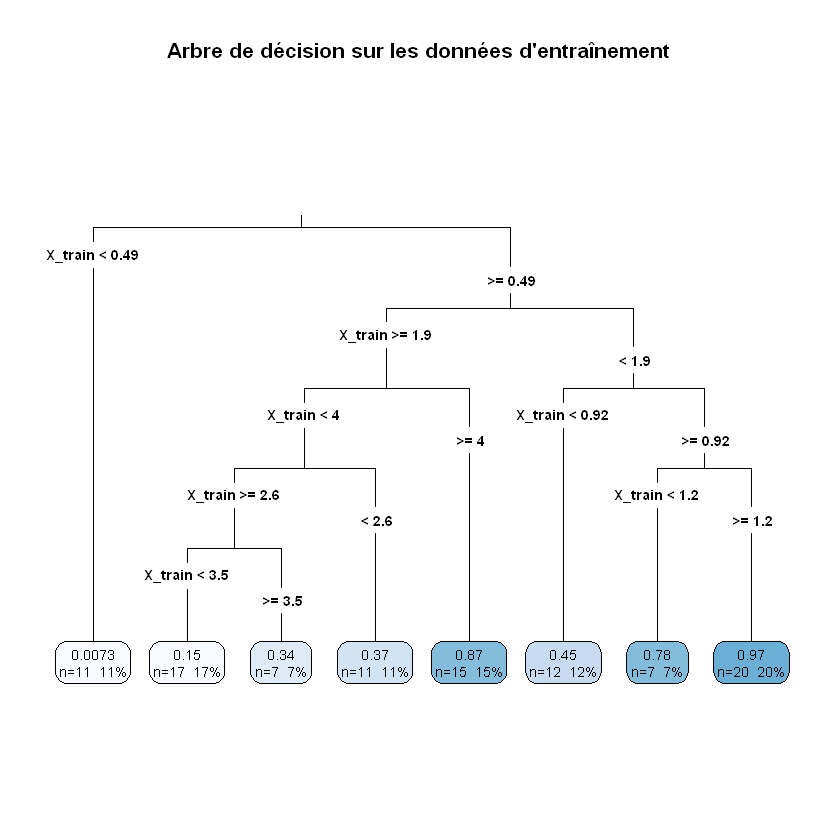

In [10]:
#png("arbres_décision.png", width = 2000, height = 1500, res = 200)  # Taille et résolution pour la qualité de l'image

# Entraînement de notre arbre de décision
tree_model <- rpart(y_train ~ X_train, data = Xtrain_data, method = "anova")

# Visualisation de l'arbre de décision
rpart.plot(tree_model, type = 3, extra = 101, main = "Arbre de décision sur les données d'entraînement")

#dev.off()

Ci-dessus on a l'arbre de décision utilisé pour entrainer pour entrainer le modèle.

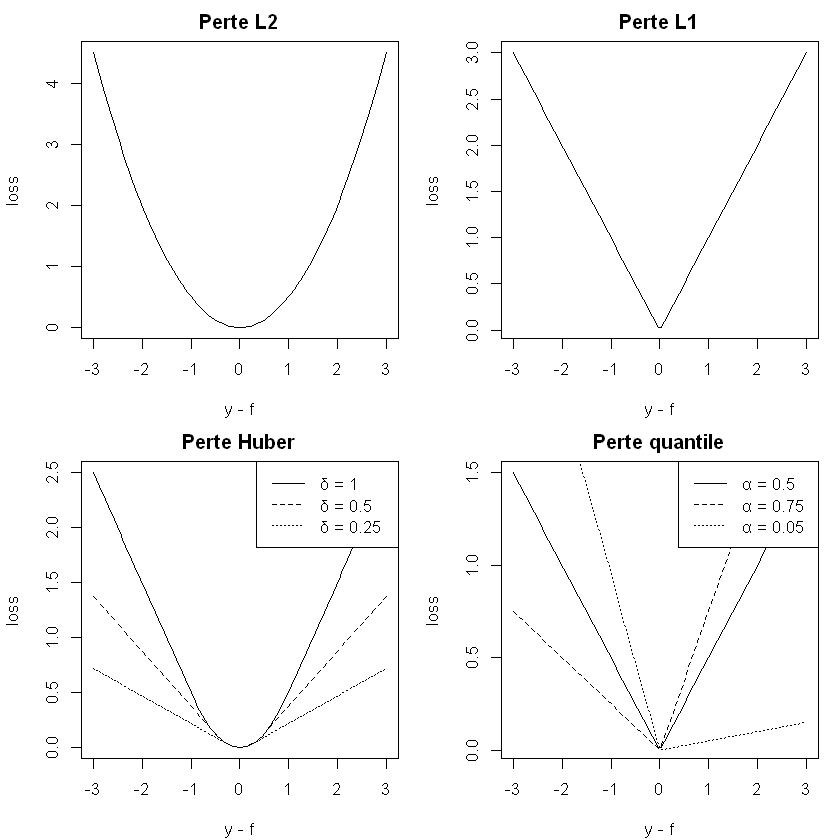

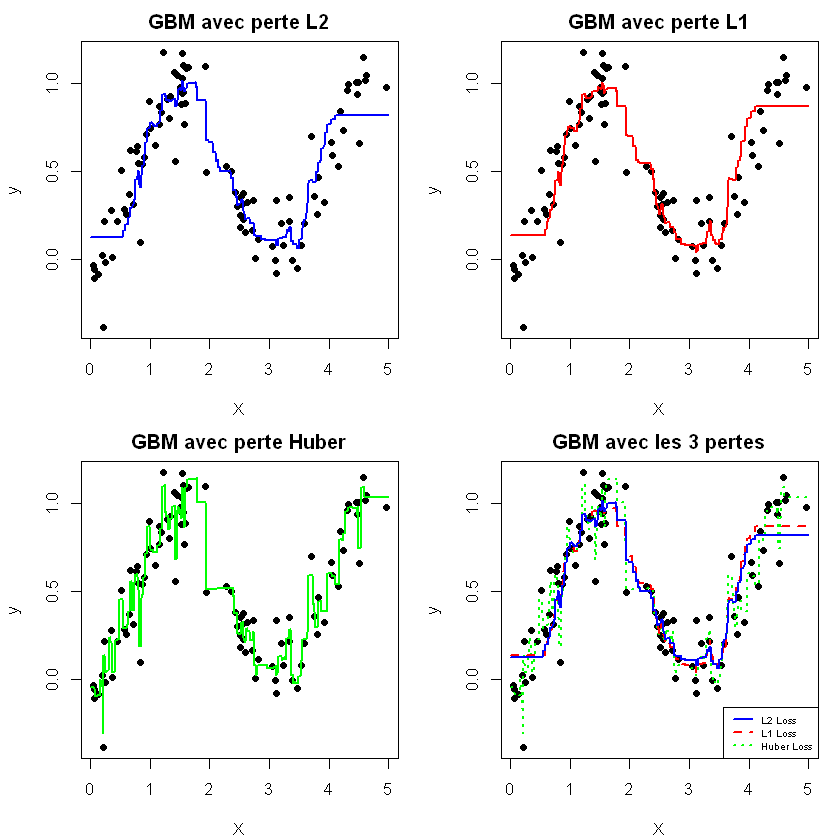

In [11]:
#png("graphes_FonctionPerte.png", width = 2000, height = 1000, res = 200)  # Taille et résolution pour la qualité

# Configuration de la grille pour nos graphiques
par(mfrow = c(2, 2), mar = c(4, 4, 2, 1) + 0.1)  # Ajuster les marges pour plus d'espace

# Tracer les fonctions de perte
plot(y_f, L2_loss(y_f, 0), type = "l", ylab = "loss", xlab = "y - f", main = "Perte L2") # Perte L2

plot(y_f, L1_loss(y_f, 0), type = "l", ylab = "loss", xlab = "y - f", main = "Perte L1") # Perte L1

plot(y_f, Huber_loss(y_f, 0, delta = 1), type = "l", ylab = "loss", xlab = "y - f", main = "Perte Huber") # Perte Huber pour différents deltas
lines(y_f, Huber_loss(y_f, 0, delta = 0.5), lty = 2)
lines(y_f, Huber_loss(y_f, 0, delta = 0.25), lty = 3)
legend("topright", legend = c("δ = 1", "δ = 0.5", "δ = 0.25"), lty = 1:3)

plot(y_f, Quantile_loss(y_f, 0, alpha = 0.5), type = "l", ylab = "loss", xlab = "y - f", main = "Perte quantile") # Perte Quantile pour différents alphas
lines(y_f, Quantile_loss(y_f, 0, alpha = 0.75), lty = 2)
lines(y_f, Quantile_loss(y_f, 0, alpha = 0.05), lty = 3)
legend("topright", legend = c("α = 0.5", "α = 0.75", "α = 0.05"), lty = 1:3)

# Graphe des prédictions L2
plot(X_train, y_train, col = "black", pch = 16, main = "GBM avec perte L2",
     xlab = "X", ylab = "y")
lines(X_test, y_pred_L2, col = "blue", lwd = 2, lty = 1)     # Prédictions avec L2

# Graphe des prédictions L1
plot(X_train, y_train, col = "black", pch = 16, main = "GBM avec perte L1",
     xlab = "X", ylab = "y")
lines(X_test, y_pred_L1, col = "red", lwd = 2, lty = 1)      # Prédictions avec L1

# Graphe des prédictions Huber
plot(X_train, y_train, col = "black", pch = 16, main = "GBM avec perte Huber",
     xlab = "X", ylab = "y")
lines(X_test, y_pred_Huber, col = "green", lwd = 2, lty = 1) # Prédictions avec Huber

# Graphe des prédictions des 3 Fonctions de perte
plot(X_train, y_train, col = "black", pch = 16, main = "GBM avec les 3 pertes",
     xlab = "X", ylab = "y")
lines(X_test, y_pred_Huber, col = "green", lwd = 2, lty = 3) # Prédictions avec Huber
lines(X_test, y_pred_L1, col = "red", lwd = 2, lty = 2)      # Prédictions avec L1
lines(X_test, y_pred_L2, col = "blue", lwd = 2, lty = 1)     # Prédictions avec L2

legend(x = "bottomright", legend = c("L2 Loss", "L1 Loss", "Huber Loss"),
       col = c("blue", "red", "green"), lty = c(1, 2, 3), lwd = 2,
       box.lwd = 0.3, cex = 0.6)

In [12]:
install.packages("remotes")

remotes::install_github("gbm-developers/gbm3")

Installing package into 'C:/Users/ibrah/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'remotes' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ibrah\AppData\Local\Temp\RtmpKACOjE\downloaded_packages


Skipping install of 'gbm3' from a github remote, the SHA1 (e12ab2c7) has not changed since last install.
  Use `force = TRUE` to force installation



### Illustration pour un exemple de classification : Pertes Bernoulli et Adaboost

#### Fonctions de perte

In [13]:
# Fonction de perte Bernoulli
bernoulli_loss <- function(y, f) {
  log(1 + exp(-y * f))
}

# Fonction de perte Adaboost
adaboost_loss <- function(y, f) {
  exp(-y * f)
}

#### Notre jeu de données

In [14]:
set.seed(123)

# Générons des données pour deux classes
n <- 200
x1 <- matrix(rnorm(n * 2), ncol = 2) + matrix(c(1, 1), nrow = n, ncol = 2, byrow = TRUE) # Classe "0" par exemple
x2 <- matrix(rnorm(n * 2), ncol = 2) - matrix(c(1, 1), nrow = n, ncol = 2, byrow = TRUE) # Et celle-ci la classe "1"

x <- rbind(x1, x2)
y <- c(rep(1, n), rep(-1, n))

data0 <- data.frame(x1 = x[, 1], x2 = x[, 2], y = as.factor(y))

In [15]:
data0$y <- ifelse(data0$y == -1, 0, 1)

#### Construction de nos modèles

In [16]:
# Modèle GBM avec perte Bernoulli
model_gbm_bernoulli <- gbm(y ~ x1 + x2, data = data0, distribution = "bernoulli", n.trees = 100)

# Modèle GBM avec perte Adaboost
model_gbm_adaboost <- gbm(y ~ x1 + x2, data = data0, distribution = "adaboost", n.trees = 100)

# Générer une grille pour visualiser les frontières de décision
grid <- expand.grid(
  x1 = seq(min(data0$x1) - 0.5, max(data0$x1) + 0.5, length.out = 100),
  x2 = seq(min(data0$x2) - 0.5, max(data0$x2) + 0.5, length.out = 100)
)

# Prédictions
pred_bernoulli <- predict(model_gbm_bernoulli, newdata = grid, n.trees = 100, type = "response")
pred_adaboost <- predict(model_gbm_adaboost, newdata = grid, n.trees = 100, type = "response")

In [17]:
# Conversion en classes
class_bernoulli <- ifelse(pred_bernoulli > 0.5, 1, -1)
class_adaboost <- ifelse(pred_adaboost > 0.5, 1, -1)

# Ajout des résultats dans la grille
grid$class_bernoulli <- as.factor(class_bernoulli)
grid$class_adaboost <- as.factor(class_adaboost)


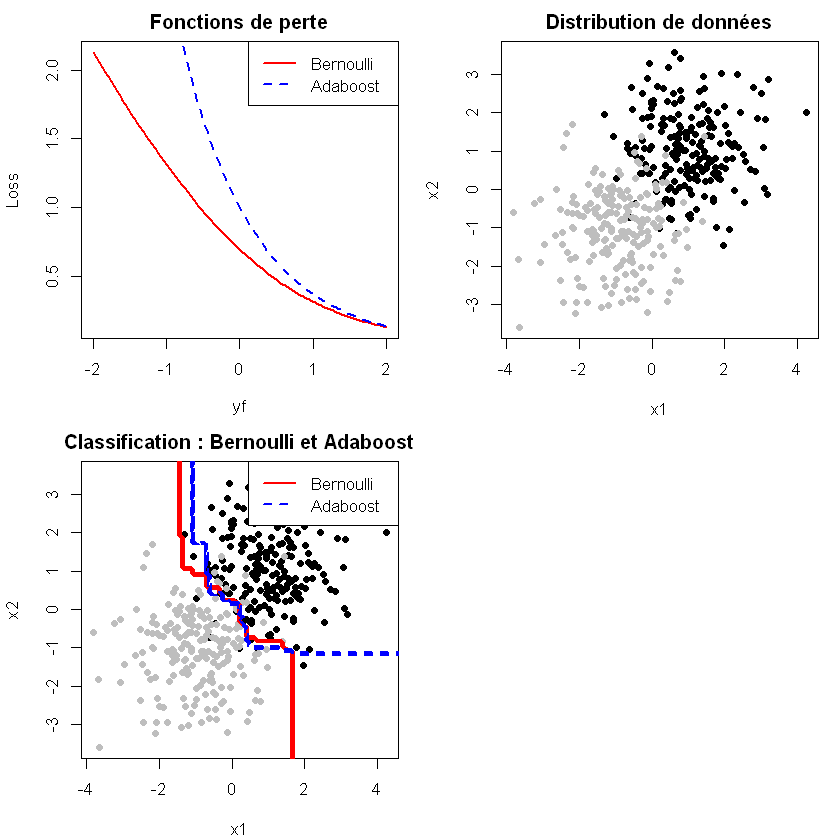

In [18]:
# Générer des valeurs de y * f pour les graphiques
yf <- seq(-2, 2, length.out = 100)

# Créer et sauvegarder les graphiques en format PNG
#png("pertes_Bernou_AdaBoost.png", width = 2000, height = 500, res = 200)  # Taille et résolution pour la qualité

# Configurer la grille de graphiques
par(mfrow = c(2,2), mar = c(4, 4, 2, 1) + 0.1)  # Ajuster les marges pour plus d'espace


# Courbe fonction de perte Bernoulli
plot(yf, bernoulli_loss(1, yf), type = "l", ylab = "Loss", xlab = expression(y * f), 
     col = "red", lty = 1, lwd = 2, main = "Fonctions de perte")

# Courbe fonction de perte Adaboost
lines(yf, adaboost_loss(1, yf), col = "blue", lty = 2, lwd = 2)

legend("topright", legend = c("Bernoulli", "Adaboost"),
       col = c("red", "blue"), lty = c(1, 2), lwd = 2)

# Graphe des de la distribution de données
plot(data0$x1, data0$x2, col = ifelse(data0$y == 1, "black", "gray"), pch = 16,
     xlab = "x1", ylab = "x2", main = "Distribution de données")

# Graphe illustratif ente Adaboost et Bernoulli
plot(data0$x1, data0$x2, col = ifelse(data0$y == 1, "black", "gray"), pch = 16,
     xlab = "x1", ylab = "x2", main = "Classification : Bernoulli et Adaboost")

# Contours pour Bernoulli
contour(unique(grid$x1), unique(grid$x2), matrix(as.numeric(grid$class_bernoulli), 100, 100),
        add = TRUE, drawlabels = FALSE, col = "red", lty = 1, lwd = 2)

# Contours pour Adaboost
contour(unique(grid$x1), unique(grid$x2), matrix(as.numeric(grid$class_adaboost), 100, 100),
        add = TRUE, drawlabels = FALSE, col = "blue", lty = 2, lwd = 2)

legend("topright", legend = c("Bernoulli", "Adaboost"),
       col = c("red", "blue"), lty = c(1, 2), lwd = 2)

#dev.off()

### Illustration du GBM pour différents nombres d'arbres en utilisant la fonction de perte L2

In [19]:
# Créons une séquence pour stocker le nombre d'arbres pour chaque modèle
arbres <- c(5, 50, 100, 1000)

# Pour les prédictions pour ces nombres d'arbres on a :
y_preds <- list()

for (i in arbres) {
  model <- gbm(y_train ~ X_train, data = Xtrain_data,
               distribution = "gaussian",
               n.trees = i,
               interaction.depth = 3,
               shrinkage = 0.1,
               n.minobsinnode = 10,
               cv.folds = 5,
               verbose = FALSE)

  # Les prédictions sur les données de test nous donnent :
  y_pred <- predict(model, newdata = data.frame(X_train = X_test), n.trees = i)
  y_preds[[as.character(i)]] <- y_pred
}

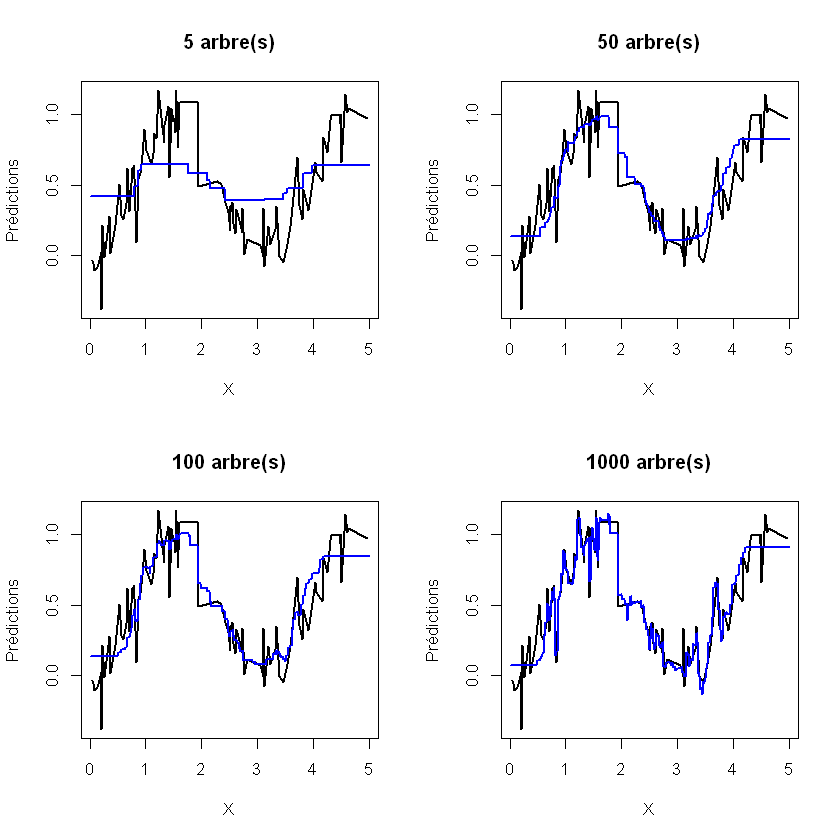

In [20]:
#png("graphes_arbre_5_50_100_1000.png", width = 2000, height = 1200, res = 200)  # Taille et résolution pour la qualité

# Configuration de la disposition des graphiques
par(mfrow = c(2, 2))  # Pour afficher les graphes comme une matrice 2x2

# Avec cette boucle on va pouvoir tracer les résultats
for (i in arbres) {
  plot(X_train, y_train, type = "l", col = "black", lwd = 2, main = paste(i, "arbre(s)"),
       xlab = "X", ylab = "Prédictions")
  lines(X_test, y_preds[[as.character(i)]], col = "blue", lwd = 2)
}

#dev.off()

# Deuxième partie : Application sur des données réelles

In [21]:
# Chargement des bibliothèques nécessaires pour notre cas pratique (on chargera les autres au fure à mesure qu'on avance)
library(tidyverse)
library(caret)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'readr' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
✖ dplyr::slice()  masks xgboost::slice()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




## Exploration des données

In [22]:
# Lecture des données
data <- read.csv('Downloads/breast_cancer.csv')

In [23]:
head(data)
str(data)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,⋯,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,⋯,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
2,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,⋯,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
3,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,⋯,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
4,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,⋯,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
5,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,⋯,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
6,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,⋯,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


'data.frame':	569 obs. of  32 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : chr  "M" "M" "M" "M" ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave_points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se             : num  0.905 0.734 0.787 1

On remarque qu'on a la variable qualitative $diagnosis$ (catégorielle) en $character$, on va d'abord transformer le "B" en "0" et le "M" en "1" puis la mettre de type $numeric$.

In [24]:
# Conversion de la variable diagnosis : on convertit le "M" en "1" et le "B" en "0"
data$diagnosis <- as.factor(ifelse(data$diagnosis == "M", 1, 0))
data$diagnosis <- as.numeric(data$diagnosis)

# Vérifier les changements
table(data$diagnosis)


  1   2 
357 212 

Avec ces sorties, on constate qu'on a 357 patients avec une tumeur bénigne (classe "0") et 212 avec une tumeur maligne (classe "1").

In [25]:
summary(data)

       id              diagnosis      radius_mean      texture_mean  
 Min.   :     8670   Min.   :1.000   Min.   : 6.981   Min.   : 9.71  
 1st Qu.:   869218   1st Qu.:1.000   1st Qu.:11.700   1st Qu.:16.17  
 Median :   906024   Median :1.000   Median :13.370   Median :18.84  
 Mean   : 30371831   Mean   :1.373   Mean   :14.127   Mean   :19.29  
 3rd Qu.:  8813129   3rd Qu.:2.000   3rd Qu.:15.780   3rd Qu.:21.80  
 Max.   :911320502   Max.   :2.000   Max.   :28.110   Max.   :39.28  
 perimeter_mean     area_mean      smoothness_mean   compactness_mean 
 Min.   : 43.79   Min.   : 143.5   Min.   :0.05263   Min.   :0.01938  
 1st Qu.: 75.17   1st Qu.: 420.3   1st Qu.:0.08637   1st Qu.:0.06492  
 Median : 86.24   Median : 551.1   Median :0.09587   Median :0.09263  
 Mean   : 91.97   Mean   : 654.9   Mean   :0.09636   Mean   :0.10434  
 3rd Qu.:104.10   3rd Qu.: 782.7   3rd Qu.:0.10530   3rd Qu.:0.13040  
 Max.   :188.50   Max.   :2501.0   Max.   :0.16340   Max.   :0.34540  
 concavity_me

In [26]:
# Vérification des valeurs manquantes
sum(is.na(data))

[1] 0

On constate qu'on a aucune valeur manquante, ce qui va nous faciliter dans la suite de notre étude.

Vu le nombre de variables qu'on a nous allons essayer de tracer le graphe des corrélations entre les variables pour avoir une idée sur comment les autres variables sont corrélées avec la variables cible $diagnosis$ de notre jeu de données. Mais vu le nombres de variables, il nous sera difficile d'utiliser certaines visualisations. Du coup on va essayer avec un barplot pour une meilleurs visualisation.

In [27]:
# Calculons la matrice de corrélation pour toutes les variables numériques
numeric_vars <- data %>% select_if(is.numeric)
correlations <- cor(numeric_vars)

# Extraire les corrélations avec la variable cible 'diagnosis'
cor_target <- correlations[, "diagnosis"]

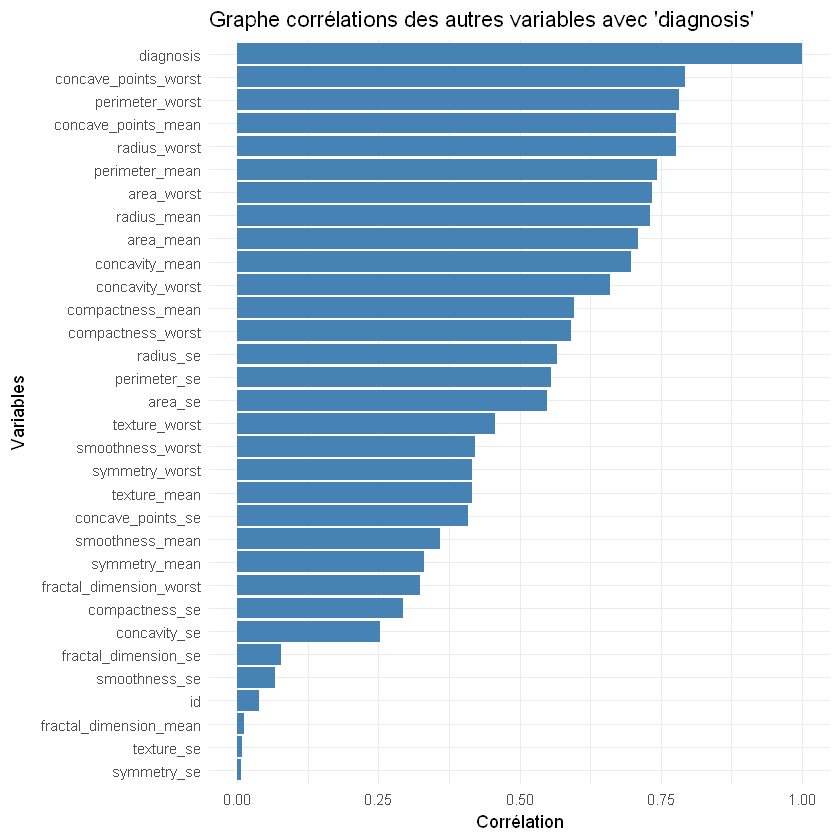

In [28]:
#png("correlations_variables.png", width = 2000, height = 1500, res = 200)  

# Créer un dataframe pour ggplot
df_strong_cor <- data.frame(variable = names(abs(cor_target)), correlation = abs(cor_target))

# Créer le barplot
ggplot(df_strong_cor, aes(x = reorder(variable, correlation), y = correlation)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +  # Inverser les axes pour une lecture plus facile
  labs(title = "Graphe corrélations des autres variables avec 'diagnosis'", 
       x = "Variables", y = "Corrélation") +
  theme_minimal()

#dev.off()

In [29]:
# Essayons de filtrer les corrélations supérieures à 0.7 (en valeur absolue)
strong_cor <- cor_target[abs(cor_target) > 0.7]

# Puis on affiches leurs noms pour les distingués des autres :
names(strong_cor)

[1] "diagnosis"            "radius_mean"          "perimeter_mean"      
[4] "area_mean"            "concave_points_mean"  "radius_worst"        
[7] "perimeter_worst"      "area_worst"           "concave_points_worst"

## Construction des modèle GBM, randomForest, SVM

### Préparation des données

Pour augmenter la robustesse des modèles ainsi que leurs qualités, commencons par séparer les données en données d'entrainement et de test avant l'utilisation de la validation croisée sur nos données d'entrainement pour tous les données.

In [30]:
# Séparons les données en ensembles d'entraînement et de test
set.seed(1234)
train_indices <- sample(1:nrow(data), size = 0.8 * nrow(data)) # On prend 80% des données pour l'entrainement du modèle
train_data <- data[train_indices, ]
test_data <- data[-train_indices, ] # le "-" devant "train_indices" c'est pour prendre le reste des données (les 20% restant)

In [31]:
# Normalisons les variables explicatives avant l'entrainement de nos modèles
preprocess <- preProcess(train_data[, -1], method = c("center", "scale"))
train_data[, -1] <- predict(preprocess, train_data[, -1])
test_data[, -1] <- predict(preprocess, test_data[, -1])

### Entrainement des modèles

#### Modèle gbm

In [32]:
# Chargeons la librairie qui nous permet de construire notre modèle de gradient boosting
library(gbm)

Pour une meilleure prédiction, nous allons partir avec un modèle à gradient boosting stochastic $(0 < bag.fraction < 1)$ pour obtenir un modèle plus robuste et efficace.

In [33]:
# Entraînement du modèle GBM
set.seed(1234)

# Mettre la variable cible est un facteur
train_data$diagnosis <- as.factor(train_data$diagnosis)
test_data$diagnosis <- as.factor(test_data$diagnosis)

# Convertir le facteur en numérique 0 et 1
train_data$diagnosis <- as.numeric(train_data$diagnosis) - 1
test_data$diagnosis<- as.numeric(test_data$diagnosis) - 1


gbm_model <- gbm(
  formula = diagnosis ~ .,
  data = train_data,
  distribution = "bernoulli",
  n.trees = 1500,
  interaction.depth = 4,
  shrinkage = 0.01,
  bag.fraction = 0.1,  # On spécifie le taux de sous-échantillonnage 
  cv.folds = 5,
  n.cores = NULL,
  verbose = FALSE
)

[1] "Meilleur nombre d'arbres: 1133"


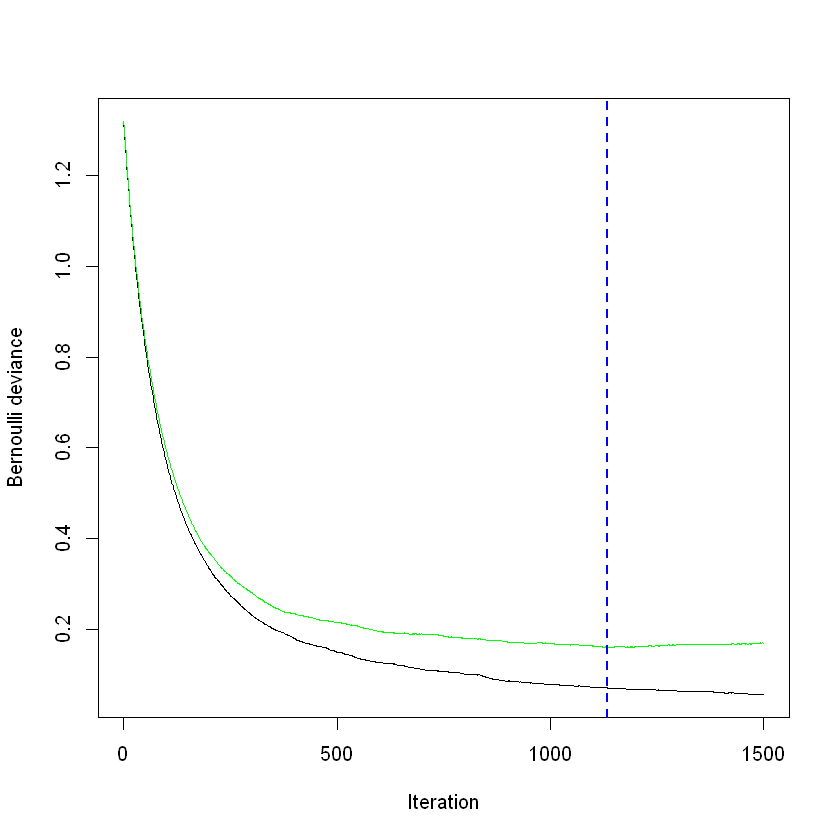

In [34]:
# Sélection du meilleur nombre d'arbres pour optimiser notre modèle
meilleur_iter <- gbm.perf(gbm_model, method = "cv")
print(paste("Meilleur nombre d'arbres:", meilleur_iter))

,var,rel.inf
,<chr>,<dbl>
concave_points_worst,concave_points_worst,16.177159
perimeter_worst,perimeter_worst,14.657247
radius_worst,radius_worst,11.407071
concave_points_mean,concave_points_mean,10.631768
concavity_mean,concavity_mean,7.217816
concavity_worst,concavity_worst,5.487470


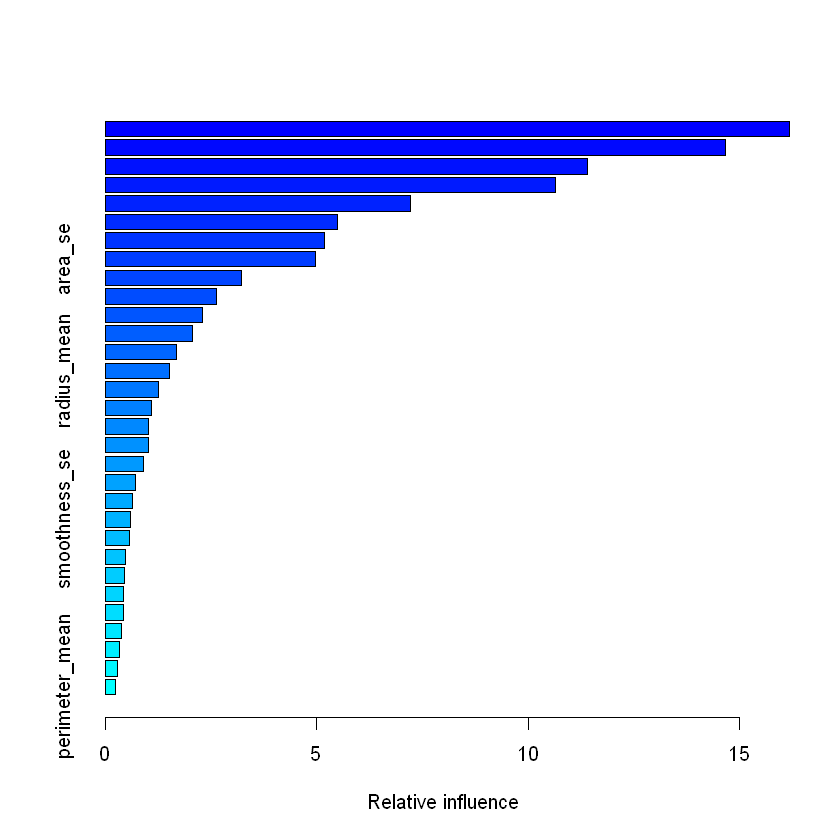

In [35]:
# Visualisation de l'importance des variables
head(summary(gbm_model, n.trees = meilleur_iter, plotit = TRUE))

Cette sortie nous aide à voir les variables explicatives qui ont une plus grande influence sur notre variable cible. Parmi elles on peut citer : 'concavity_worst', 'concavity_mean', 'concave_points_mean', 'radius_worst', 'perimeter_worst', 'concave_points_worst'. Et cela vérifie notre remarque sur les variables qui ont une forte corrélation avec notre variable cible.

#### Modèle random forest

In [36]:
install.packages("randomForest")
library(randomForest)

Installing package into 'C:/Users/ibrah/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ibrah\AppData\Local\Temp\RtmpKACOjE\downloaded_packages


Warning message:
"package 'randomForest' was built under R version 4.3.3"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [37]:
# Entraînement du modèle Random Forest
set.seed(1234)

# Assurez-vous que la variable cible est un facteur
train_data$diagnosis <- as.factor(train_data$diagnosis)

# Définissons le contrôle de validation croisée
control <- trainControl(method = "cv", number = 5) # 5-fold cross-validation

# Définir la grille de paramètres
tune_grid <- expand.grid(mtry = sqrt(ncol(train_data) - 1)) # Ajuster mtry selon vos besoins

# Entraînement du modèle avec validation croisée
rF_model <- train(diagnosis ~ ., data = train_data, method = "rf",
                     trControl = control, tuneGrid = tune_grid,
                     ntree = 1000, nodesize = 5)

In [38]:
# Prédictions du modèle Random Forest
predict_rF <- predict(rF_model, newdata = test_data)

#### Modele SVM

In [39]:
library(e1071)

Warning message:
"package 'e1071' was built under R version 4.3.3"


In [40]:
set.seed(1234)
# Assurez-vous que la variable cible est un facteur
train_data$diagnosis <- as.factor(train_data$diagnosis)
# Entraînement du modèle SVM
svm_model <- svm(diagnosis ~ ., data = train_data, kernel = "radial", cost = 10, gamma = 0.1)

In [41]:
summary(svm_model)


Call:
svm(formula = diagnosis ~ ., data = train_data, kernel = "radial", 
    cost = 10, gamma = 0.1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 

Number of Support Vectors:  191

 ( 94 97 )


Number of Classes:  2 

Levels: 
 0 1




#### Modèle Bagging

In [42]:
install.packages("earth")
library(earth)

Installing package into 'C:/Users/ibrah/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'earth' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ibrah\AppData\Local\Temp\RtmpKACOjE\downloaded_packages


Warning message:
"package 'earth' was built under R version 4.3.3"
Loading required package: Formula

Loading required package: plotmo

Warning message:
"package 'plotmo' was built under R version 4.3.3"
Loading required package: plotrix



In [43]:
# Fixer la graine pour la reproductibilité
set.seed(1234)

train_data$diagnosis <- as.factor(train_data$diagnosis)

# Créons le modèle de bagging avec un arbre de décision de base
bagging_model <- train(
  diagnosis ~ ., data = train_data,
  method = "treebag",  # Méthode de bagging avec des arbres de décision
  trControl = trainControl(method = "cv", number = 5)  # Validation croisée à 5 plis
)

## Résultats des analyses et validation des performances

#### Modèle gbm

In [45]:
# Prédictions sur l'ensemble de test pour le modèle GBM
predict_GBM <- predict(gbm_model, newdata = test_data, n.trees = meilleur_iter, type = "response")
class_GBM <- ifelse(predict_GBM > 0.5, 1, 0)

In [46]:
# Création de la matrice de confusion du modèle
conf_matrix_GBM <- confusionMatrix(as.factor(class_GBM), as.factor(test_data$diagnosis))
print(conf_matrix_GBM)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 70  0
         1  5 39
                                          
               Accuracy : 0.9561          
                 95% CI : (0.9006, 0.9856)
    No Information Rate : 0.6579          
    P-Value [Acc > NIR] : 1.136e-14       
                                          
                  Kappa : 0.9055          
                                          
 Mcnemar's Test P-Value : 0.07364         
                                          
            Sensitivity : 0.9333          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.8864          
             Prevalence : 0.6579          
         Detection Rate : 0.6140          
   Detection Prevalence : 0.6140          
      Balanced Accuracy : 0.9667          
                                          
       'Positive' Class : 0               
                                    

De part cette matrice de confusion on constate que le modèle a correctement identifié toutes les tumeurs Bénignes (70) des données test sans se tromper et a donc Zéro (0) tumeur Bénigne mal classée. Tandis que qu'il a mal classé 5 tumeurs Malignes en tumeurs Bénignes, et correctement identifié 39 tumeurs Malignes.

In [47]:
# Extraction des métriques
accuracy_GBM <- conf_matrix_GBM$overall['Accuracy']
precision_GBM <- conf_matrix_GBM$byClass['Pos Pred Value']
recall_GBM <- conf_matrix_GBM$byClass['Sensitivity']

#### Modèle randomForest

In [48]:
# Prédictions du modèle Random Forest
predict_rF <- predict(rF_model, newdata = test_data)

In [49]:
# Matrice de confusion du modèle
conf_matrix_rF <- confusionMatrix(as.factor(predict_rF), as.factor(test_data$diagnosis))
print(conf_matrix_rF)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 71  2
         1  4 37
                                         
               Accuracy : 0.9474         
                 95% CI : (0.889, 0.9804)
    No Information Rate : 0.6579         
    P-Value [Acc > NIR] : 1.095e-13      
                                         
                  Kappa : 0.8845         
                                         
 Mcnemar's Test P-Value : 0.6831         
                                         
            Sensitivity : 0.9467         
            Specificity : 0.9487         
         Pos Pred Value : 0.9726         
         Neg Pred Value : 0.9024         
             Prevalence : 0.6579         
         Detection Rate : 0.6228         
   Detection Prevalence : 0.6404         
      Balanced Accuracy : 0.9477         
                                         
       'Positive' Class : 0              
                                         


On constate que le modèle a correctement identifié 71 tumeurs Bénignes et 37 tumeurs Malignes. Tandis que qu'il a mal classé 4 tumeurs Malignes en tumeurs Bénignes, et 2 tumeurs Bénignes en tumeurs Malignes.

In [50]:
# Extraction des métriques de notre modèle
accuracy_rF <- conf_matrix_rF$overall['Accuracy']
precision_rF <- conf_matrix_rF$byClass['Pos Pred Value']
recall_rF <- conf_matrix_rF$byClass['Sensitivity']

#### Modèle SVM

In [51]:
# Prédictions du modèle SVM
predict_svm <- predict(svm_model, newdata = test_data)

In [52]:
# Matrice de confusion du modèle
conf_matrix_svm <- confusionMatrix(as.factor(predict_svm), as.factor(test_data$diagnosis))
print(conf_matrix_svm)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 62  1
         1 13 38
                                          
               Accuracy : 0.8772          
                 95% CI : (0.8025, 0.9312)
    No Information Rate : 0.6579          
    P-Value [Acc > NIR] : 8.304e-08       
                                          
                  Kappa : 0.7459          
                                          
 Mcnemar's Test P-Value : 0.003283        
                                          
            Sensitivity : 0.8267          
            Specificity : 0.9744          
         Pos Pred Value : 0.9841          
         Neg Pred Value : 0.7451          
             Prevalence : 0.6579          
         Detection Rate : 0.5439          
   Detection Prevalence : 0.5526          
      Balanced Accuracy : 0.9005          
                                          
       'Positive' Class : 0               
                                    

De meme, d'après ce qu'on voit le modèle a correctement identifié 62 tumeurs Bénignes et 38 tumeurs Malignes. Tandis que qu'il a mal classé 13 tumeurs Malignes en tumeurs Bénignes, et 1 tumeurs Bénigne en tumeurs Maligne.

In [53]:
# Extraction des métriques du modèle SVM
accuracy_svm <- conf_matrix_svm$overall['Accuracy']
precision_svm <- conf_matrix_svm$byClass['Pos Pred Value']
recall_svm <- conf_matrix_svm$byClass['Sensitivity']

#### Modèle Bagging (bootstrap)

In [54]:
# Prédictions du modèle de Bagging
predict_bagging <- predict(bagging_model, newdata = test_data)

In [55]:
# Matrice de confusion de notre modèle
conf_matrix_bagging <- confusionMatrix(as.factor(predict_bagging), as.factor(test_data$diagnosis))
print(conf_matrix_bagging)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 71  2
         1  4 37
                                         
               Accuracy : 0.9474         
                 95% CI : (0.889, 0.9804)
    No Information Rate : 0.6579         
    P-Value [Acc > NIR] : 1.095e-13      
                                         
                  Kappa : 0.8845         
                                         
 Mcnemar's Test P-Value : 0.6831         
                                         
            Sensitivity : 0.9467         
            Specificity : 0.9487         
         Pos Pred Value : 0.9726         
         Neg Pred Value : 0.9024         
             Prevalence : 0.6579         
         Detection Rate : 0.6228         
   Detection Prevalence : 0.6404         
      Balanced Accuracy : 0.9477         
                                         
       'Positive' Class : 0              
                                         


On constate que le modèle a correctement identifié 71 tumeurs Bénignes et 37 tumeurs Malignes. Tandis que qu'il a mal classé 4 tumeurs Malignes en tumeurs Bénignes, et 2 tumeurs Bénignes en tumeurs Malignes.

In [56]:
# Extraction des métriques de notre modèle
accuracy_bagging <- conf_matrix_bagging$overall['Accuracy']
precision_bagging <- conf_matrix_bagging$byClass['Pos Pred Value']
recall_bagging <- conf_matrix_bagging$byClass['Sensitivity']

In [57]:
# Chargeons la librairie qui nous permet de visualiser l'ensembles graphes en une grille
library(gridExtra)

Warning message:
"package 'gridExtra' was built under R version 4.3.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:randomForest':

    combine


The following object is masked from 'package:dplyr':

    combine




## Visualisation des métriques des modèles

In [58]:
# Création du graphique à barres 

# Pour le modèle GBM
metriques_GBM <- data.frame(
  Metrique_GBM = c("Accuracy", "Precision", "Recall"),
  Valeur_GBM = c(accuracy_GBM, precision_GBM, recall_GBM)
)

# Pour le modèle randamForest
metriques_rF <- data.frame(
  Metrique_rF = c("Accuracy", "Precision", "Recall"),
  Valeur_rF = c(accuracy_rF, precision_rF, recall_rF)
)

# Pour le modèle Bagging
metriques_bagging <- data.frame(
  Metrique_bagging = c("Accuracy", "Precision", "Recall"),
  Valeur_bagging = c(accuracy_bagging, precision_bagging, recall_bagging)
)

# Pour le modèle SVM
metriques_svm <- data.frame(
  Metrique_svm = c("Accuracy", "Precision", "Recall"),
  Valeur_svm = c(accuracy_svm, precision_svm, recall_svm)
)

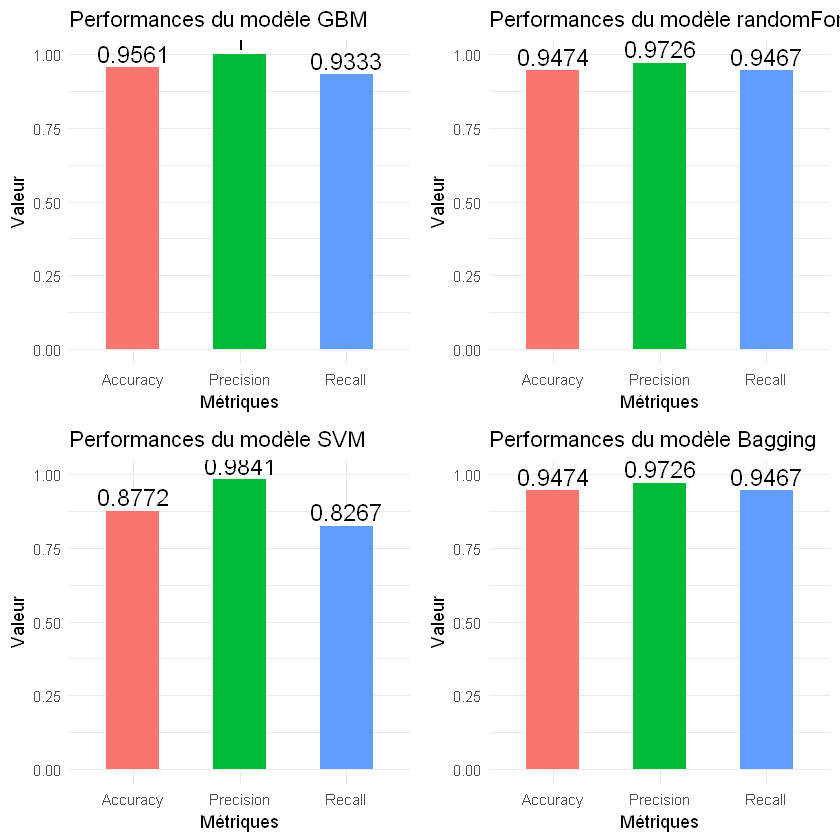

In [59]:
#png("graphes_recall_accuracy_.png", width = 2000, height = 1000, res = 200)  # Taille et résolution pour la qualité de l'image

# Graphe des métriques pour le modèle GBM
plot_GBM <- ggplot(metriques_GBM, aes(x = Metrique_GBM, y = Valeur_GBM, fill = Metrique_GBM)) +
  geom_bar(stat = "identity", width = 0.5) +
  geom_text(aes(label = round(Valeur_GBM, 4)), vjust = -0.3, size = 5) +
  scale_y_continuous(limits = c(0, 1)) +
  labs(title = "Performances du modèle GBM", x = "Métriques", y = "Valeur") +
  theme_minimal() +
  theme(legend.position = "none")

# Graphe des métriques pour le modèle randomForest
plot_rF <- ggplot(metriques_rF, aes(x = Metrique_rF, y = Valeur_rF, fill = Metrique_rF)) +
  geom_bar(stat = "identity", width = 0.5) +
  geom_text(aes(label = round(Valeur_rF, 4)), vjust = -0.3, size = 5) +
  scale_y_continuous(limits = c(0, 1)) +
  labs(title = "Performances du modèle randomForest", x = "Métriques", y = "Valeur") +
  theme_minimal() +
  theme(legend.position = "none")

# Graphe des métriques pour le modèle SVM
plot_svm <- ggplot(metriques_svm, aes(x = Metrique_svm, y = Valeur_svm, fill = Metrique_svm)) +
  geom_bar(stat = "identity", width = 0.5) +
  geom_text(aes(label = round(Valeur_svm, 4)), vjust = -0.3, size = 5) +
  scale_y_continuous(limits = c(0, 1)) +
  labs(title = "Performances du modèle SVM", x = "Métriques", y = "Valeur") +
  theme_minimal() +
  theme(legend.position = "none")

# Graphe des métriques pour le modèle Bagging
plot_Bagging <- ggplot(metriques_bagging, aes(x = Metrique_bagging, y = Valeur_bagging, fill = Metrique_bagging)) +
  geom_bar(stat = "identity", width = 0.5) +
  geom_text(aes(label = round(Valeur_bagging, 4)), vjust = -0.3, size = 5) +
  scale_y_continuous(limits = c(0, 1)) +
  labs(title = "Performances du modèle Bagging", x = "Métriques", y = "Valeur") +
  theme_minimal() +
  theme(legend.position = "none")

# Créns une matrice 2x2 de graphiques pour afficher les métriques de nos 4 modèles
combined_plots <- grid.arrange(plot_GBM, plot_rF, plot_svm, plot_Bagging, nrow = 2, ncol = 2)


#dev.off()

Le modèle GBM se distingue par sa précision globale ($accuracy$) élévée ($95,61%$) et sa $précision$ de $100%$ ce qui veut dire qu'il fait aucune erreur lorsqu'il s'agit d'identifier une tumeur Maligne ("1"). Par contre, son $recall$ de $93,33%$ prouve qu'ilen manque quelques unes. Les modèles randomForest et Bagging, avec des métriques très similaires, sont presque aussi précis ($accuracy = 94,74%$), et détectent un peu mieux les tumeurs Malignes ($recall = 94,67%$) que le modèle GBM. Ce peut les rendre plus fiables lorsqu'il s'agit de détecter de faux négatifs. Lemodèle SVM, quant à lui, est le moins performant des quatres modèles. Meme avec une bonne $précision$ ($98,41%$), le modèle a plus de cas manqués. Ce qui fait de lui le modèle qui occupe la dernière place de de notre classement (sur ce jeu de données bien sùr).

## Amélioration du modèle GBM

#### Optimisation des hyperparamètres

In [60]:
# Grille de paramètres pour la recherche des meillurs hyperparamètres pour notre modèle
grid <- expand.grid(
  n.trees = seq(100, 1500, by = 500),
  interaction.depth = seq(1, 5, by = 1),
  shrinkage = c(0.001, 0.01, 0.1)
)
grid

n.trees,interaction.depth,shrinkage
<dbl>,<dbl>,<dbl>
100,1,0.001
600,1,0.001
1100,1,0.001
100,2,0.001
600,2,0.001
1100,2,0.001
100,3,0.001
600,3,0.001
1100,3,0.001


In [61]:
set.seed(1234)

train_data$diagnosis <- as.factor(train_data$diagnosis)
test_data$diagnosis <- as.factor(test_data$diagnosis)

train_data$diagnosis <- as.numeric(train_data$diagnosis) - 1
test_data$diagnosis<- as.numeric(test_data$diagnosis) - 1

# Effectuons la recherche sur grille avec la technique de la validation croisée
results <- list()
for (i in 1:nrow(grid)) {
  model <- gbm(
    formula = diagnosis ~ .,
    data = train_data,
    distribution = "bernoulli",
    n.trees = grid$n.trees[i],
    interaction.depth = grid$interaction.depth[i],
    shrinkage = grid$shrinkage[i],
    bag.fraction = 0.5,
    cv.folds = 5,
    n.cores = NULL,
    verbose = FALSE
  )
  best_iter <- gbm.perf(model, method = "cv", plot.it = FALSE)
    # Ici on va stocker les résultats : hyperparamètres et itération optimale
  results <- rbind(results, c(grid[i, ], best_iter = best_iter))
}

# Pour la conversion en data frame pour manipulation plus aisée on obtient :
results <- as.data.frame(results)

In [62]:
# Ce code nous aide à trouver la combinaison avec la meilleure (plus petite) itération à partir de notre boucle "for"
bon_model <- results[which.min(results$best_iter), ]
print(bon_model)

   n.trees interaction.depth shrinkage best_iter
45    1100                 5       0.1        47


#### Régularisation du modèle gbm

Après avoir trouvé de bons paramètres (pas uniquement les seuls meilleurs), on va ainsi essayer de régulariser notre modèle en l'injectant les paramètres qu'on a pu obtenir de notre recherche sur grille.

In [63]:
# Entrainement du modèle

set.seed(1234)
# Convertissons les hyperparamètres en numeric
bon_model$n.trees <- as.numeric(bon_model$n.trees)
bon_model$interaction.depth  <- as.numeric(bon_model$interaction.depth)
bon_model$shrinkage  <- as.numeric(bon_model$shrinkage)


# Au lieu de réécrire les chiffres tels que afficher en haut, on va plutot utiliser les variable de notre dataframe qu'on a mis en "numeric"
# et va directement les injecter dans l'entrainement de notre modèle.
meilleur_model_GBM <- gbm(
  formula = diagnosis ~ .,
  data = train_data,
  distribution = "bernoulli",
  n.trees = bon_model$n.trees,
  interaction.depth = bon_model$interaction.depth,
  shrinkage = bon_model$shrinkage,
  bag.fraction = 0.81,
  cv.folds = 5,
  n.cores = NULL,
  verbose = FALSE
)

[1] "Meilleur nombre d'arbres: 63"


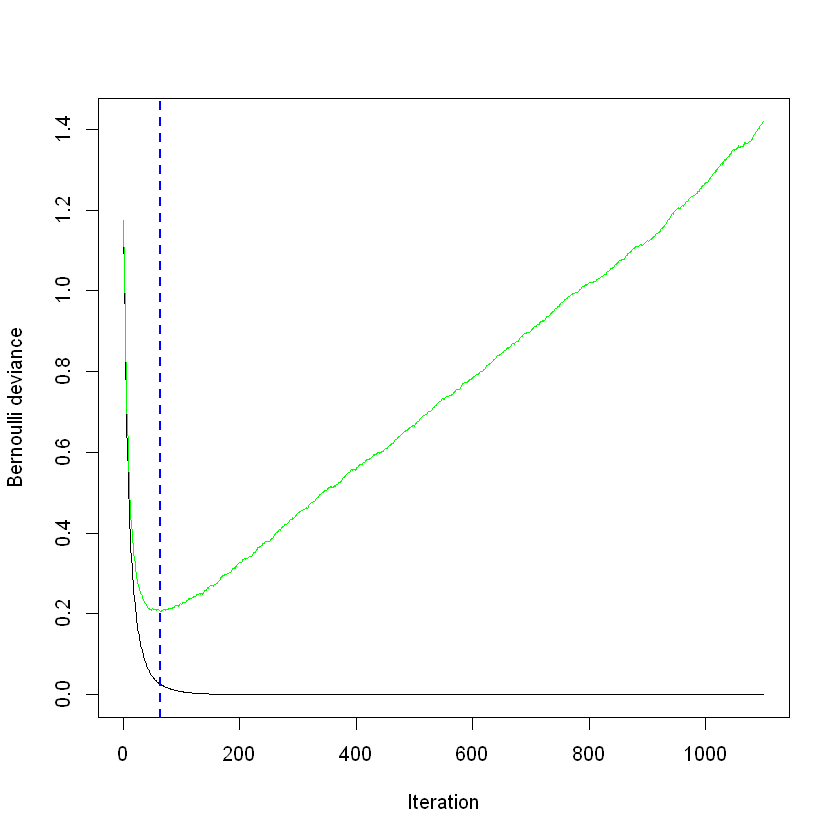

In [64]:
# Après on sélectionne le meilleur nombre d'arbres pour optimiser notre modèle
meilleur_iter2 <- gbm.perf(meilleur_model_GBM, method = "cv")
print(paste("Meilleur nombre d'arbres:", meilleur_iter2))

Pour pousser notre recherche sur l'efficacité de notre modèle gradient boosting nous allons essayer de le comparer au modèle XGBoost qui est une version améliorée du boosting lui-meme.

#### Modèle xgboost

In [65]:
#On charge le package qui nous permet d'entrainer notre modèle XGBoost
install.packages("xgboost")
library(xgboost)

Warning message:
"package 'xgboost' is in use and will not be installed"


In [66]:
set.seed(1234)

train_data$diagnosis <- as.factor(train_data$diagnosis)
test_data$diagnosis <- as.factor(test_data$diagnosis)

# Convertir le facteur en numérique 0 et 1 (Vérifiez que les valeurs sont 0 et 1)
train_data$diagnosis <- as.numeric(train_data$diagnosis) - 1
test_data$diagnosis <- as.numeric(test_data$diagnosis) - 1


# Séparons les variables explicatives et la cible
train_x <- as.matrix(train_data[, setdiff(names(train_data), "diagnosis")])
train_y <- train_data$diagnosis
test_x <- as.matrix(test_data[, setdiff(names(test_data), "diagnosis")])
test_y <- test_data$diagnosis

In [67]:
# Puis nous créons sa matrice de données DMatrix
dtrain <- xgb.DMatrix(data = train_x, label = train_y)
dtest <- xgb.DMatrix(data = test_x, label = test_y)

In [68]:
# Paramètres du modèle XGBoost
params <- list(
  objective = "binary:logistic",  # Pour une classification binaire
  eval_metric = "logloss",         # Métrique d'évaluation
  max_depth = 4,                   # Profondeur des arbres
  eta = 0.01,                      # Taux d'apprentissage
  subsample = 0.1                  # Taux de sous-échantillonnage
)


In [69]:
# Maintenat entraînons notre modèle XGBoost
xgboost_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 1500,  # Le nombre d'arbres
  watchlist = list(train = dtrain, eval = dtest),  # Liste de surveillance pour validation
  verbose = 0  # Cette fois-ci pas de sortie verbosité
)

## Résultats et validation des performance

#### Modèle gbm

In [70]:
# Prédictions sur l'ensemble de test pour le modèle GBM amélioré
predict_GBM2 <- predict(meilleur_model_GBM, newdata = test_data, n.trees = meilleur_iter2, type = "response")
class_GBM2 <- ifelse(predict_GBM2 > 0.5, 1, 0)

In [71]:
# Création de la matrice de confusion du modèle
conf_matrix_GBM2 <- confusionMatrix(as.factor(class_GBM2), as.factor(test_data$diagnosis))
print(conf_matrix_GBM2)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 72  2
         1  3 37
                                          
               Accuracy : 0.9561          
                 95% CI : (0.9006, 0.9856)
    No Information Rate : 0.6579          
    P-Value [Acc > NIR] : 1.136e-14       
                                          
                  Kappa : 0.9032          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9600          
            Specificity : 0.9487          
         Pos Pred Value : 0.9730          
         Neg Pred Value : 0.9250          
             Prevalence : 0.6579          
         Detection Rate : 0.6316          
   Detection Prevalence : 0.6491          
      Balanced Accuracy : 0.9544          
                                          
       'Positive' Class : 0               
                                    

On constate alors meme après amélioration des hyperparamètres la précision du modèle ne change pas considérablement, ce qui peu etre dù du nombre de données de test ou encore que le modèle ne peut plus dépasser cette performance.

In [72]:
# Extraction des métriques du modèle GBM amélioré
accuracy_GBM2 <- conf_matrix_GBM2$overall['Accuracy']
precision_GBM2 <- conf_matrix_GBM2$byClass['Pos Pred Value']
recall_GBM2 <- conf_matrix_GBM2$byClass['Sensitivity']

#### Modèle xgboost

In [73]:
# Prédictions sur les données de test
predict_xgboost <- predict(xgboost_model, newdata = dtest)
class_xgboost <- ifelse(predict_xgboost > 0.5, 1, 0)
test_y_factor <- factor(test_y, levels = c(0, 1))

In [74]:
# Créons la matrice de confusion du modèle XGBoost
conf_matrix_xgboost <- confusionMatrix(factor(class_xgboost, levels = c(0, 1)), test_y_factor)
print(conf_matrix_xgboost)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 73  2
         1  2 37
                                          
               Accuracy : 0.9649          
                 95% CI : (0.9126, 0.9904)
    No Information Rate : 0.6579          
    P-Value [Acc > NIR] : 9.744e-16       
                                          
                  Kappa : 0.9221          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9733          
            Specificity : 0.9487          
         Pos Pred Value : 0.9733          
         Neg Pred Value : 0.9487          
             Prevalence : 0.6579          
         Detection Rate : 0.6404          
   Detection Prevalence : 0.6579          
      Balanced Accuracy : 0.9610          
                                          
       'Positive' Class : 0               
                                    

In [75]:
# Extraction des métriques du modèle XGBoost
accuracy_xgboost <- conf_matrix_xgboost$overall['Accuracy']
precision_xgboost <- conf_matrix_xgboost$byClass['Pos Pred Value']
recall_xgboost <- conf_matrix_xgboost$byClass['Sensitivity']

#### Visualisation des précisions

In [76]:

# Les métriques du modèle XGBoost
metriques_xgboost <- data.frame(
  Metrique_xgboost = c("Accuracy", "Precision", "Recall"),
  Valeur_xgboost = c(accuracy_xgboost, precision_xgboost, recall_xgboost)
)

# Les métriques du modèle BGM amélioré
metriques_GBM2 <- data.frame(
  Metrique_GBM2 = c("Accuracy", "Precision", "Recall"),
  Valeur_GBM2 = c(accuracy_GBM2, precision_GBM2, recall_GBM)
)

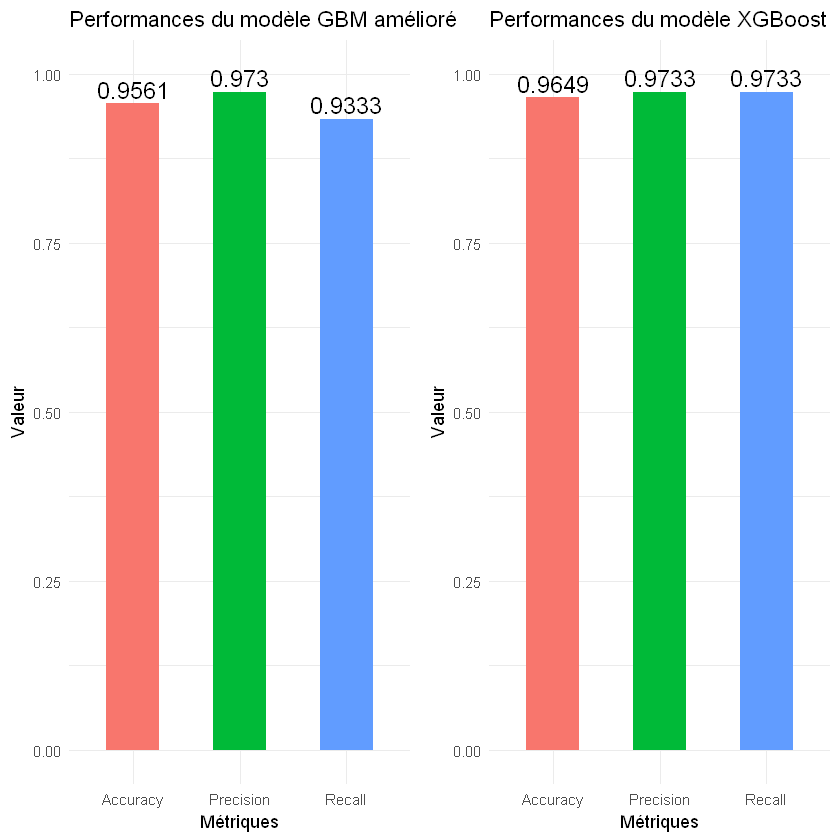

In [77]:

#png("graphes_GBM2_xgboost.png", width = 2000, height = 1000, res = 200)  # Taille et résolution pour la qualité

# Graphique GBM2
plot_GBM2 <- ggplot(metriques_GBM2, aes(x = Metrique_GBM2, y = Valeur_GBM2, fill = Metrique_GBM2)) +
  geom_bar(stat = "identity", width = 0.5) +
  geom_text(aes(label = round(Valeur_GBM2, 4)), vjust = -0.3, size = 5) +
  scale_y_continuous(limits = c(0, 1)) +
  labs(title = "Performances du modèle GBM amélioré", x = "Métriques", y = "Valeur") +
  theme_minimal() +
  theme(legend.position = "none")

# Graphe xgboost
plot_xgboost <- ggplot(metriques_xgboost, aes(x = Metrique_xgboost, y = Valeur_xgboost, fill = Metrique_xgboost)) +
  geom_bar(stat = "identity", width = 0.5) +
  geom_text(aes(label = round(Valeur_xgboost, 4)), vjust = -0.3, size = 5) +
  scale_y_continuous(limits = c(0, 1)) +
  labs(title = "Performances du modèle XGBoost", x = "Métriques", y = "Valeur") +
  theme_minimal() +
  theme(legend.position = "none")

# Créons une matrice 1x2 de graphiques pour afficher les métrqiues des 2 modèles
combined_plots <- grid.arrange(plot_GBM2, plot_xgboost, nrow = 1, ncol = 2)


#dev.off()